In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


## Котировки

In [27]:
df = pd.read_csv('Data/TQBR.SBER_D1.txt', sep='\t')

In [28]:
def func_1(x):
    
    return datetime.strptime(x[:10], '%d.%m.%Y')

df.datetime = df.datetime.apply(lambda x: func_1(x))
df.datetime = df.datetime.astype('datetime64')

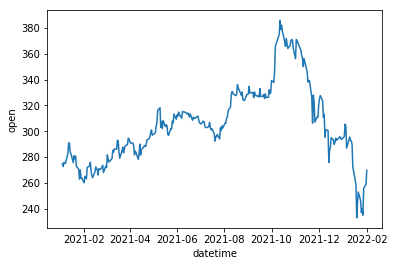

In [29]:
sns.lineplot(data=df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')], x="datetime", y="open")

In [30]:
df = df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].set_index('datetime')
df.head()

,open,high,low,close,volume
datetime,,,,,
2021-01-04,274.67,276.60,270.61,272.00,4879946
2021-01-05,272.67,275.70,270.28,275.20,4555410
2021-01-06,275.90,275.92,271.62,272.93,4090534
2021-01-08,275.11,283.99,275.11,283.64,8867294
2021-01-11,282.75,292.95,279.48,289.49,11221040


## Индикатор

In [ ]:
#CCI = (TP - SMA 20 OF TP) / (0.15 * MEAN DEVIATION)where,
#Typical Price (TP) = (HIGH + LOW + CLOSE) / 3
#SMA 20 of TP = Typical Price / 20
#Mean Deviation = Absolute values of Typical Price / 20

In [6]:
# Commodity Channel Index 
def CCI(df): 
    
    df['TP'] = (df['high'] + df['low'] + df['close']) / 3 
    df['sma'] = df['TP'].rolling(20).mean()
    df['mad'] = df['TP'].rolling(20).apply(lambda x: pd.Series(x).mad())
    df['cci'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
    
    return df['cci']

In [14]:
df['cci'] = CCI(df)

In [16]:
df

,open,high,low,close,volume,TP,sma,mad,cci
datetime,,,,,,,,,
2021-01-04,274.67,274.67,272.54,273.95,1051383,273.720000,NaN,NaN,NaN
2021-01-04,273.95,276.28,273.93,275.06,1499956,275.090000,NaN,NaN,NaN
2021-01-04,274.96,276.60,273.77,273.80,1674926,274.723333,NaN,NaN,NaN
2021-01-04,273.83,273.90,270.61,272.00,653681,272.170000,NaN,NaN,NaN
2021-01-05,272.67,273.28,270.28,272.38,1255856,271.980000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-02-11,274.90,275.87,272.61,273.53,810792,274.003333,269.589833,7.725517,38.085910
2022-02-11,273.53,274.68,266.58,267.76,5956437,269.673333,270.196500,7.058183,-4.941467
2022-02-11,267.76,269.80,264.99,267.83,6584398,267.540000,270.758167,6.440350,-33.312544


## TRADING STRATEGY

In [17]:
# TRADING STRATEGY

def cci_signals(prices, cci):
    
    buy_price = []
    sell_price = []
    cci_signal = []
    signal = 0
    
    lower_band = (-100)
    upper_band = 100
    
    for i in range(len(prices)):
        if cci[i-1] > lower_band and cci[i] < lower_band:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                cci_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                cci_signal.append(0)
                
        elif cci[i-1] < upper_band and cci[i] > upper_band:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                cci_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                cci_signal.append(0)
                
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            cci_signal.append(0)
            
    return buy_price, sell_price, cci_signal



In [ ]:
df['cci'] = CCI(df)

In [9]:
buy_price, sell_price, cci_signal = implement_cci_strategy(df['close'], df['cci'])

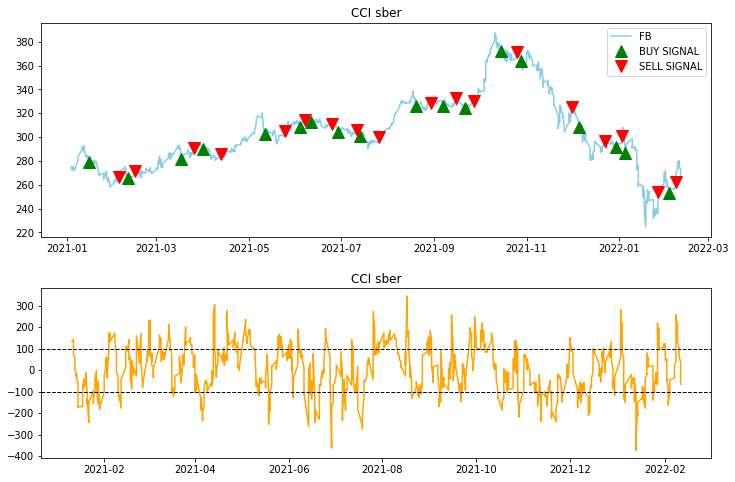

In [13]:
prod_name = 'sber'
signals_plot(df, buy_price, sell_price, prod_name)

In [12]:
def signals_plot(df, buy_price, sell_price, prod_name):

    plt.figure(figsize=(12,8))    
    ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
    ax1.plot(df['close'], color = 'skyblue', label = 'FB')
    ax1.plot(df.index, buy_price, marker = '^', markersize = 12, linewidth = 0, label = 'BUY SIGNAL', color = 'green')
    ax1.plot(df.index, sell_price, marker = 'v', markersize = 12, linewidth = 0, label = 'SELL SIGNAL', color = 'r')
    ax1.set_title('CCI ' + prod_name)
    ax1.legend()
    ax2.plot(df['cci'], color = 'orange')
    ax2.set_title('CCI ' + prod_name)
    ax2.axhline(100, linestyle = '--', linewidth = 1, color = 'black')
    ax2.axhline(-100, linestyle = '--', linewidth = 1, color = 'black')
    plt.show()

In [18]:
def get_position(df, cci_signal):

    position = []
    for i in range(len(cci_signal)):
        if cci_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)
            
    for i in range(len(df['close'])):
        if cci_signal[i] == 1:
            position[i] = 1
        elif cci_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    cci = df['cci']
    close_price = df['close']
    cci_signal = pd.DataFrame(cci_signal).rename(columns = {0:'cci_signal'}).set_index(df.index)
    position = pd.DataFrame(position).rename(columns = {0:'cci_position'}).set_index(df.index)
    
    frames = [close_price, cci, cci_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)
    
    return strategy

## общий запуск

In [23]:
def get_signals(prod_name, df):
    
    print('----------------------------')
    print(prod_name)
    
    df['cci'] = CCI(df)
    df = df.dropna()
    
    buy_price, sell_price, cci_signal = cci_signals(df['close'], df['cci'])

    signals_plot(df, buy_price, sell_price, prod_name)
    strategy = get_position(df, cci_signal)
    
    return strategy

----------------------------
TQBR.SBER_4H1


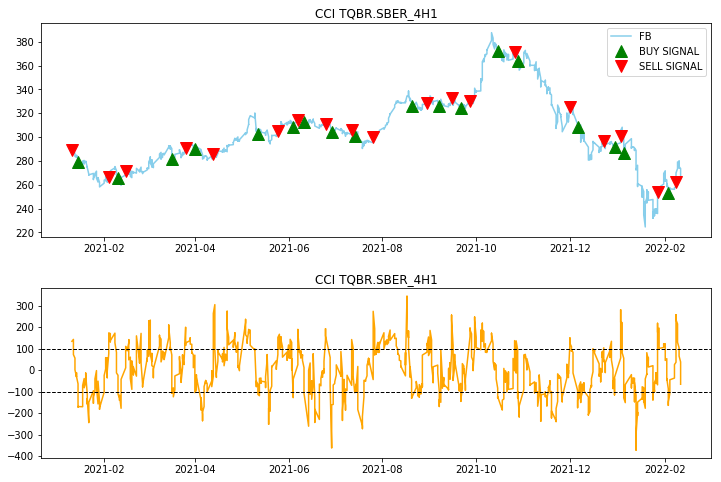

In [25]:
strategy = get_signals('TQBR.SBER_4H1', df)

In [26]:
strategy 

,close,cci,cci_signal,cci_position
datetime,,,,
2021-01-11,289.49,134.055769,-1,0
2021-01-12,292.50,142.892917,0,0
2021-01-12,292.27,123.540384,0,0
2021-01-12,287.87,78.757903,0,0
2021-01-12,289.99,72.060873,0,0
...,...,...,...,...
2022-02-11,273.53,38.085910,0,0
2022-02-11,267.76,-4.941467,0,0
2022-02-11,267.83,-33.312544,0,0


## BACKTEST